<a href="https://colab.research.google.com/github/VasantiP/fastai/blob/main/bunnies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gradio Pets

In [7]:
!pip install -Uqq fastai


In [ ]:
from fastai.vision.all import *
from fastcore.all import *

In [ ]:
from duckduckgo_search import DDGS #DuckDuckGo
def search_images(keywords, max_images=200): 
    return L(DDGS().images(keywords=keywords, max_results=max_images)).itemgot('image')

In [15]:
urls = search_images('bunny photos', max_images=1)
urls[0]

C:\Users\vasan\AppData\Local\Temp\ipykernel_32180\2583285632.py:2: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords=keywords, max_results=max_images)).itemgot('image')


'https://www.rd.com/wp-content/uploads/2021/04/GettyImages-476744133-scaled.jpg?w=2560'

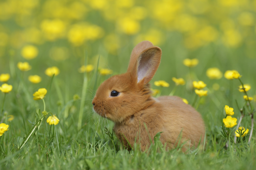

In [16]:
from fastdownload import download_url
dest = 'bunny.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256, 256)

C:\Users\vasan\AppData\Local\Temp\ipykernel_32180\2583285632.py:2: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords=keywords, max_results=max_images)).itemgot('image')


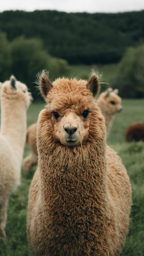

In [19]:
download_url(search_images('llama photos', max_images=1)[0], 'llama.jpg', show_progress=False)
Image.open('llama.jpg').to_thumb(256, 256)

In [20]:
searches = 'bunny', 'llama'
path = Path('bunny_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

C:\Users\vasan\AppData\Local\Temp\ipykernel_32180\2583285632.py:2: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords=keywords, max_results=max_images)).itemgot('image')
C:\Users\vasan\AppData\Local\Temp\ipykernel_32180\2583285632.py:2: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  return L(DDGS().images(keywords=keywords, max_results=max_images)).itemgot('image')


In [34]:
# remove any photos that do not download correctly
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

23

C:\Users\vasan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)
C:\Users\vasan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\matplotlib\cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, sub

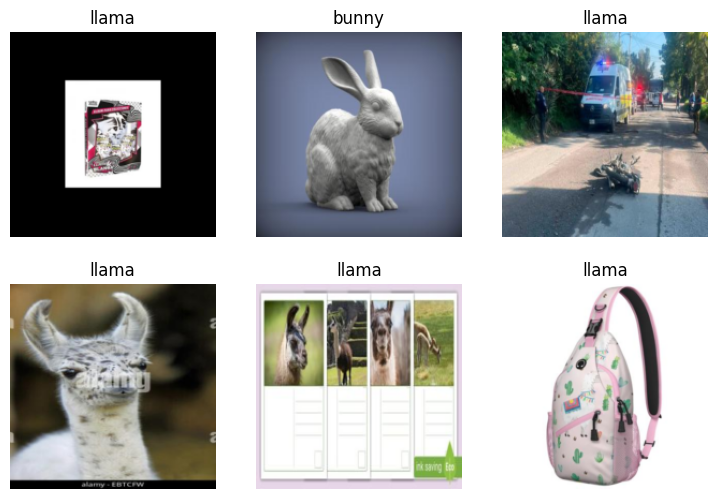

In [37]:
dls = ImageDataLoaders.from_path_func(path=path,
    fnames=get_image_files(path), valid_pct=0.2, seed=42,
    label_func=parent_label,
    item_tfms=[Resize(192, method='squish')])

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.199251,0.055582,0.016915,00:44


epoch,train_loss,valid_loss,error_rate,time
0,0.073143,0.059040,0.013532,00:45
1,0.045075,0.040870,0.011502,00:45
2,0.020936,0.035669,0.009472,00:44


In [ ]:
is_bunny,_,probs = learn.predict(PILImage.create('bunny.jpg'))
print(f'This is a : {is_bunny}.')
print(f"Probability it's a bird: {probs[0]:.4f}")

In [ ]:
learn.export('model.pkl')